In [1]:
!pip install requests pandas scikit-learn


  Using cached pandas-2.3.1-cp311-cp311-win_amd64.whl (11.3 MB)
  Using cached scikit_learn-1.7.1-cp311-cp311-win_amd64.whl (8.9 MB)
  Using cached numpy-2.3.2-cp311-cp311-win_amd64.whl (13.1 MB)
  Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
  Using cached scipy-1.16.0-cp311-cp311-win_amd64.whl (38.6 MB)
  Using cached joblib-1.5.1-py3-none-any.whl (307 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)



[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
import pandas as pd

def load_wallets(csv_path):
    df = pd.read_csv(csv_path)
    
    # Standardize column names
    df.columns = [col.strip().lower() for col in df.columns]
    
    if 'address' in df.columns:
        return df['address'].dropna().tolist()
    else:
        raise KeyError("Column 'address' not found in the CSV.")

# Load wallet addresses
wallets = load_wallets("Wallet.csv")

# Show first 5
wallets[:5]


['0x0039f22efb07a647557c7c5d17854cfd6d489ef3',
 '0x06b51c6882b27cb05e712185531c1f74996dd988',
 '0x0795732aacc448030ef374374eaae57d2965c16c',
 '0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9',
 '0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae']

In [19]:
import pandas as pd

df = pd.read_csv("Wallet.csv")
print("Actual columns in the file:", df.columns.tolist())


Actual columns in the file: ['address']


In [20]:
import requests

SUBGRAPH_URL = "https://api.thegraph.com/subgraphs/name/graphprotocol/compound-v2"

def fetch_account_activity(wallet_address):
    query = """
    query getAccount($id: ID!) {
      account(id: $id) {
        id
        tokenTransactions(first: 1000, orderBy: blockTimestamp, orderDirection: desc) {
          __typename
        }
      }
    }
    """
    variables = {"id": wallet_address.lower()}
    
    response = requests.post(SUBGRAPH_URL, json={'query': query, 'variables': variables})
    
    if response.status_code == 200:
        data = response.json().get("data", {}).get("account", None)
        return data
    else:
        print(f"Error fetching: {wallet_address}")
        return None


In [21]:
def extract_features(account_data):
    txs = account_data.get("tokenTransactions", [])
    
    num_txs = len(txs)
    borrow_count = sum(1 for tx in txs if tx.get('__typename') == 'Borrow')
    supply_count = sum(1 for tx in txs if tx.get('__typename') == 'Mint')
    repay_count = sum(1 for tx in txs if tx.get('__typename') == 'RepayBorrow')
    liquidation_count = sum(1 for tx in txs if tx.get('__typename') == 'Liquidation')
    
    return {
        "wallet": account_data.get('id', 'unknown'),
        "num_transactions": num_txs,
        "supply_count": supply_count,
        "borrow_count": borrow_count,
        "repay_count": repay_count,
        "liquidation_count": liquidation_count
    }


In [22]:
from sklearn.preprocessing import MinMaxScaler

def compute_scores(feature_df):
    df = feature_df.copy()
    df["repay_ratio"] = df["repay_count"] / (df["borrow_count"] + 1)
    df["liquidation_risk"] = df["liquidation_count"] / (df["num_transactions"] + 1)

    features_to_scale = ["borrow_count", "repay_ratio", "liquidation_risk", "num_transactions"]
    
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df[features_to_scale])
    
    df["score"] = (1 - df_scaled[:, 2]) * 0.4 + df_scaled[:, 1] * 0.3 + df_scaled[:, 0] * 0.2 + df_scaled[:, 3] * 0.1
    df["score"] = (df["score"] * 1000).round().astype(int)
    
    return df[["wallet", "score"]]


In [25]:
def extract_features(account):
    txs = account.get("tokenTransactions", [])

    borrow_count = 0
    repay_count = 0
    liquidation_count = 0

    for tx in txs:
        tx_type = tx.get("__typename", "")
        if tx_type == "Borrow":
            borrow_count += 1
        elif tx_type == "Repay":
            repay_count += 1
        elif tx_type == "Liquidation":
            liquidation_count += 1

    return {
        "borrow_count": borrow_count,
        "repay_count": repay_count,
        "liquidation_count": liquidation_count,
        "num_transactions": len(txs)
    }


In [26]:
features = []
for wallet in wallets:
    print(f"Fetching: {wallet}")
    account = fetch_account_activity(wallet)
    if account:
        features.append(extract_features(account))
    time.sleep(0.5)

df_features = pd.DataFrame(features)
print("df_features columns:", df_features.columns.tolist())
print(df_features.head())


Fetching: 0x0039f22efb07a647557c7c5d17854cfd6d489ef3
Fetching: 0x06b51c6882b27cb05e712185531c1f74996dd988
Fetching: 0x0795732aacc448030ef374374eaae57d2965c16c
Fetching: 0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9
Fetching: 0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae
Fetching: 0x104ae61d8d487ad689969a17807ddc338b445416
Fetching: 0x111c7208a7e2af345d36b6d4aace8740d61a3078
Fetching: 0x124853fecb522c57d9bd5c21231058696ca6d596
Fetching: 0x13b1c8b0e696aff8b4fee742119b549b605f3cbc
Fetching: 0x1656f1886c5ab634ac19568cd571bc72f385fdf7
Fetching: 0x1724e16cb8d0e2aa4d08035bc6b5c56b680a3b22
Fetching: 0x19df3e87f73c4aaf4809295561465b993e102668
Fetching: 0x1ab2ccad4fc97c9968ea87d4435326715be32872
Fetching: 0x1c1b30ca93ef57452d53885d97a74f61daf2bf4f
Fetching: 0x1e43dacdcf863676a6bec8f7d6896d6252fac669
Fetching: 0x22d7510588d90ed5a87e0f838391aaafa707c34b
Fetching: 0x24b3460622d835c56d9a4fe352966b9bdc6c20af
Fetching: 0x26750f1f4277221bdb5f6991473c6ece8c821f9d
Fetching: 0x27f72a000d8e9f324583f3a3491ea66998

In [28]:
!pip install matplotlib seaborn


  Using cached matplotlib-3.10.3-cp311-cp311-win_amd64.whl (8.1 MB)
  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
                                              0.0/225.2 kB ? eta -:--:--
     -----                                 30.7/225.2 kB 660.6 kB/s eta 0:00:01
     ------                                41.0/225.2 kB 393.8 kB/s eta 0:00:01
     ---------------                       92.2/225.2 kB 751.6 kB/s eta 0:00:01
     ----------------------------------     204.8/225.2 kB 1.0 MB/s eta 0:00:01
     -------------------------------------- 225.2/225.2 kB 1.1 MB/s eta 0:00:00
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
  Using cached fonttools-4.59.0-cp311-cp311-win_amd64.whl (2.3 MB)
  Using cached kiwisolver-1.4.8-cp311-cp311-win_amd64.whl (71 kB)
  Using cached pillow-11.3.0-cp311-cp311-win_amd64.whl (7.0 MB)
  Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)



[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


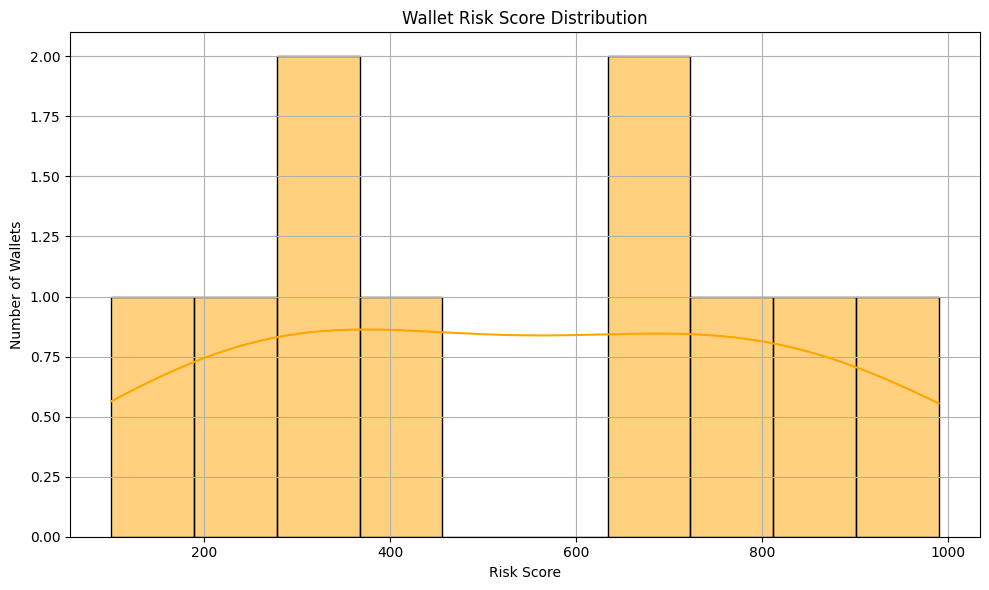

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example list of scores
scores = [350, 700, 900, 450, 100, 650, 780, 220, 990, 300]

# Plot the scores
plt.figure(figsize=(10, 6))
sns.histplot(scores, bins=10, kde=True, color='orange')
plt.title('Wallet Risk Score Distribution')
plt.xlabel('Risk Score')
plt.ylabel('Number of Wallets')
plt.grid(True)
plt.tight_layout()
plt.show()
